In [8]:
# clean old dirc
%cd ..
!rm -r LSTM-stock-predict
!rm LSTM-stock-predict.zip
!rm -r __MACOSX
!ls

/content
sample_data


In [9]:
# after uploading
!unzip LSTM-stock-predict.zip
%cd LSTM-stock-predict

Archive:  LSTM-stock-predict.zip
   creating: LSTM-stock-predict/
  inflating: LSTM-stock-predict/NN_project_main.ipynb  
   creating: __MACOSX/
   creating: __MACOSX/LSTM-stock-predict/
  inflating: __MACOSX/LSTM-stock-predict/._NN_project_main.ipynb  
  inflating: LSTM-stock-predict/run.py  
  inflating: __MACOSX/LSTM-stock-predict/._run.py  
   creating: LSTM-stock-predict/core/
  inflating: LSTM-stock-predict/core/data_processor.py  
   creating: __MACOSX/LSTM-stock-predict/core/
  inflating: __MACOSX/LSTM-stock-predict/core/._data_processor.py  
  inflating: LSTM-stock-predict/core/sp500_last2.csv  
  inflating: __MACOSX/LSTM-stock-predict/core/._sp500_last2.csv  
  inflating: LSTM-stock-predict/core/sp500_last2_beta.csv  
  inflating: LSTM-stock-predict/core/__init__.py  
  inflating: __MACOSX/LSTM-stock-predict/core/.___init__.py  
  inflating: LSTM-stock-predict/core/model.py  
  inflating: __MACOSX/LSTM-stock-predict/core/._model.py  
  inflating: LSTM-stock-predict/core/utils

In [10]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
import pickle
from core.data_processor import DataLoader
from core.model import Model
from sklearn.metrics import r2_score


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    print("plotting...")
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


# load the configs
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

# point by point model
model_PBP = Model()
model_PBP.build_model(configs)


# out-of memory generative training
steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])

x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)



# start training PBP model
model_PBP.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=configs['model']['save_dir']
)

# start predicting
predictions_PBP = model_PBP.predict_point_by_point(x_test)

# save the model
pickle.dump(model_PBP, open("model_PBP_baseline.pkl", 'wb'))



# same for multi-sequence predicting
model_MS = Model()
model_MS.build_model(configs)

model_MS.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=configs['model']['save_dir']
)


predictions_MS = model_MS.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])


# Save model

pickle.dump(model_MS, open("model_MS_baseline.pkl", 'wb'))
    
    


[Model] Model Compiled
Time taken: 0:00:00.579687
[Model] Training Started
[Model] 25 epochs, 64 batch size, 62 batches per epoch
Epoch 1/25
62/62 [==============================] - 9s 144ms/step - loss: 0.0011
Epoch 2/25
62/62 [==============================] - 7s 106ms/step - loss: 6.6167e-04
Epoch 3/25
62/62 [==============================] - 7s 106ms/step - loss: 5.0736e-04
Epoch 4/25
62/62 [==============================] - 7s 106ms/step - loss: 4.3188e-04
Epoch 5/25
62/62 [==============================] - 7s 116ms/step - loss: 3.9804e-04
Epoch 6/25
62/62 [==============================] - 8s 122ms/step - loss: 3.7910e-04
Epoch 7/25
62/62 [==============================] - 7s 112ms/step - loss: 3.6643e-04
Epoch 8/25
62/62 [==============================] - 7s 106ms/step - loss: 3.4843e-04
Epoch 9/25
62/62 [==============================] - 7s 106ms/step - loss: 3.2587e-04
Epoch 10/25
62/62 [==============================] - 7s 106ms/step - loss: 3.2064e-04
Epoch 11/25
62/62 [====

680/680 [==============================] - 2s 3ms/step
test mse loss : 8.719010408693815e-05
denormalized test mae loss:14.46
denormalized test mse loss:467.90
before de-normalization :


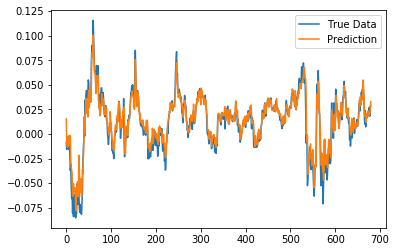

after de-normalization :


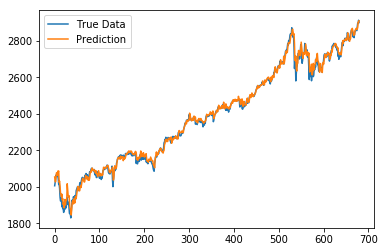

In [11]:
# plotting point-by-point predictions with/without denormalization

# denormalize point by point
x_test_true, y_test_true =data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=False
)


predictions_PBP_true = []
for i, p in enumerate(predictions_PBP):
  predictions_PBP_true.append((1+p) * data.data_test[i][0])
  
# calculate mae, mse
mae_sigma, mse_sigma = 0, 0
normalized_mae_sigma, normalized_mse_sigma = 0, 0
for i in range(650):
  normalized_mae_sigma += abs(y_test[i][0] - predictions_PBP[i])
  normalized_mse_sigma += (y_test[i][0] - predictions_PBP[i]) ** 2
  
  mae_sigma += abs(y_test_true[i][0] - predictions_PBP_true[i])
  mse_sigma += (y_test_true[i][0] - predictions_PBP_true[i]) ** 2
test_loss = model_PBP.model.evaluate(x_test, y_test)
print("test mse loss :", test_loss)

print("denormalized test mae loss:" + '%.2f' %(mae_sigma/len(predictions_PBP_true)))
print("denormalized test mse loss:" + '%.2f' %(mse_sigma/len(predictions_PBP_true)))


print("before de-normalization :")
plot_results(predictions_PBP, y_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
print("after de-normalization :")
ax.plot(y_test_true, label='True Data')
plt.plot(predictions_PBP_true, label='Prediction')
plt.legend()
plt.show()

680/680 [==============================] - 2s 3ms/step
cols : ['Close', 'Volume', 'Open', 'High', 'Low', 'Rocr100', 'Plus_dm']
test mse loss : 7.237900777802091e-05
denormalized test mae loss:55.73
denormalized test mse loss:6347.66
before de-normalization :


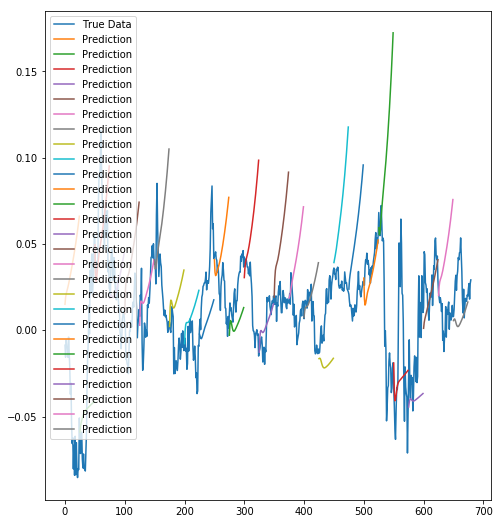

after de-normalization :


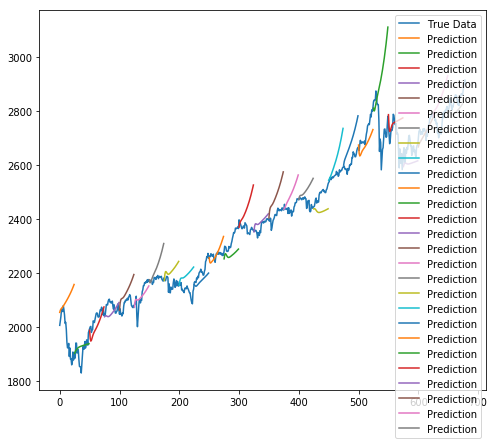

In [13]:
# plotting multi-sequence predictions with/without denormalization

import numpy as np
window_size = 25
def denormalise_windows(original_data, window_data, single_window=False):
  '''De-Normalise windows'''
  denormalised_data = []  
  window_data = np.array(window_data).astype(float)
  
  window_data = [window_data] if single_window else window_data
  for i, window in enumerate(window_data):
    denormalised_window = []
    p0 = original_data[i*window_size][0]
    for col_i in window:
      denormalised_col = (col_i+1) * p0
      denormalised_window.append(denormalised_col)
    denormalised_data.append(denormalised_window)
  return denormalised_data


def plot_results_multiple2(predicted_data, true_data, prediction_len, height, width):
    fig = plt.figure(figsize=(8, width), facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    
    for i, d in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + d, label='Prediction')
        plt.legend()
    plt.show()

  
x_test_true, y_test_true =data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=False
)

                 
predictions_MS_true = denormalise_windows(data.data_test, predictions_MS, False)
# calculate mse

mae_sigma, mse_sigma = 0, 0
normalized_mae_sigma, normalized_mse_sigma = 0, 0
for i in range(650):
  normalized_mae_sigma += abs(y_test[i][0] - predictions_MS[i//window_size][i%window_size])
  normalized_mse_sigma += (y_test[i][0] - predictions_MS[i//window_size][i%window_size]) ** 2
  
  mae_sigma += abs(y_test_true[i][0] - predictions_MS_true[i//window_size][i%window_size])
  mse_sigma += (y_test_true[i][0] - predictions_MS_true[i//window_size][i%window_size]) ** 2
test_loss = model_MS.model.evaluate(x_test, y_test)
data_length = len(predictions_MS) * len(predictions_MS[0])
print("cols :", configs['data']['columns'])
print("test mse loss :", test_loss)

print("denormalized test mae loss:" + '%.2f' %(mae_sigma/data_length))
print("denormalized test mse loss:" + '%.2f' %(mse_sigma/data_length))


print("before de-normalization :")
plot_results_multiple2(predictions_MS, y_test, configs['data']['sequence_length'], 5, 9)
print("after de-normalization :")
plot_results_multiple2(predictions_MS_true, y_test_true, configs['data']['sequence_length'], 8, 7)

